For this notebook, you need to install : 
+ ODFTT from Mumott's package : https://gitlab.com/liebi-group/software/odf-mumott

# 5 - Plot 3D tomogram

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import odftt.plot_tools
from tqdm import tqdm
import pickle
import h5py
import sys

from odftt.analysis.grid_tools import distance_matrix, mean_orientations_inside_radius

from utils import *
from scipy.spatial.transform import Rotation as R

from odftt.io import load_series
from odftt.texture import grids, point_groups, odfs
from odftt.tomography_models import FromArrayModel
from odftt.crystallography import cubic
from odftt.optimization import FISTA

from mumott import Geometry 


INFO:Setting the number of threads to 8. If your physical cores are fewer than this number, you may want to use numba.set_num_threads(n), and os.environ["OPENBLAS_NUM_THREADS"] = f"{n}" to set the number of threads to the number of physical cores n.
INFO:Setting numba log level to WARNING.


### Parameters of the experiment

In [2]:
z_slice_index = 1

## Put your experiment number and the date of the beginning of the xperiment below
experiment_number = 'ma6795'
experiment_date = '20250826'
detector = 'eiger'
sample ='textom_posth14_post_beamdown'

print()
with h5py.File(f'auxillary_files/{sample}_corrected_data.h5', 'r') as file:

    rot_angles = np.array(file['rotangle_degrees'])
    azim_angles = np.array(file['aziangle_degrees'])
    data_shape = file['data_array'].shape
    hkl_list = np.array(file['hkl_list'])
    gap_mask = np.array(file['gap_mask'])
    coordinates = np.array(file['coordinates'])

# Should maybe be read from a file instead
geometry = Geometry()
geometry.read('auxillary_files/3d.mumottgeometry')

# Model quantitites
basis_function_arrys = []
with h5py.File('auxillary_files/ODF_model_data.h5', 'r') as file:
    grid = R.from_euler('zyz', file['grid'])
    kernel_sigma = float(file['sigma'][...])

A, B = cubic()

Plot the convergence curves for every reconstructed slices

100%|██████████| 3/3 [00:00<00:00, 10.46it/s]


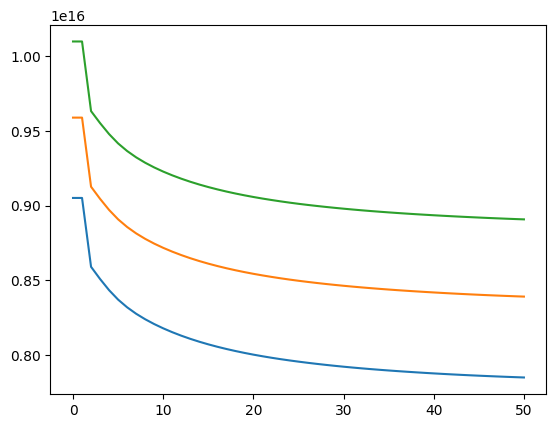

In [3]:
volume_shape = (*geometry.volume_shape[:2], data_shape[2])

coefficients = np.zeros((*volume_shape, len(grid)))
for z_slize in tqdm(range(data_shape[2])):
    with h5py.File(f'reconstruction_output_z{z_slize}.h5', 'r') as file:
        convergence_curve = np.array(file['convergence_curve'])
        plt.plot(convergence_curve)
        coefficients[:, :, data_shape[2] - 1 - z_slize, :] = np.array(file['coefficients'])[:,:,0,:]


In [4]:
print(f'volume shape : {volume_shape}')

volume shape : (83, 83, 3)


Set up the reconstruction model

In [5]:
odf = odfs.GaussianRBF(grid, point_groups.octahedral, kernel_sigma)

+ **mask_threshold**: Pick a threshold value to determine what pixels to plot. <br />
This value should sit in between the two bumps

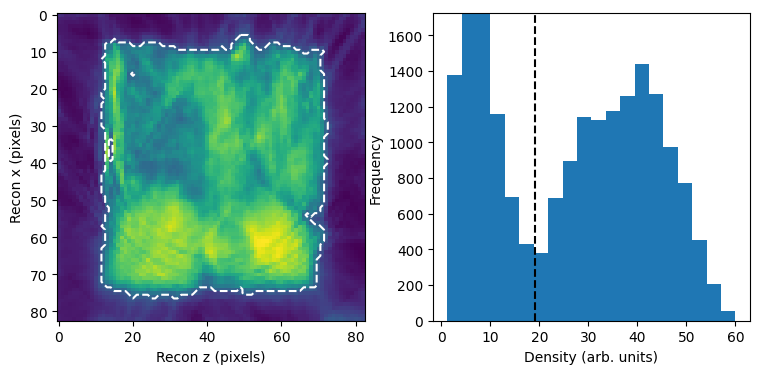

In [6]:
mask_threshold = 19

plt.figure(figsize = (9, 4))
dens = np.sum(coefficients, axis = -1)
mask = dens > mask_threshold

plt.subplot(1,2,1)
plt.imshow(dens[:,:,-1])
plt.contour(mask[:,:,-1], levels = [0.5], colors=[(1,1,1)],linestyles='dashed')
plt.xlabel('Recon z (pixels)'); plt.ylabel('Recon x (pixels)');

plt.subplot(1,2,2)
freq = plt.hist(dens.flatten(), bins = 20)[0]
plt.ylim(0, np.max(freq[5:])*1.2)
plt.plot([mask_threshold]*2, [0, np.max(freq[5:])*1.2], 'k--')
plt.xlabel('Density (arb. units)')
plt.ylabel('Frequency')
plt.show()


In [7]:
dist_matrix, symmetry_index, deviation_matrix = distance_matrix(odf.grid, odf.point_group, compute_misorientations=True)
mean_orientation_mat, sum_near_max = mean_orientations_inside_radius(odf.grid, coefficients, odf.point_group,  mask = mask, radius = 10,  dist_matrix=dist_matrix, deviation_matrix=deviation_matrix)


0it [00:00, ?it/s]/home/esrf/ljegou/.local/lib/python3.11/site-packages/odftt/analysis/grid_tools.py:17: RuntimeWarning: invalid value encountered in arccos
  dist_this = np.arccos(2*np.abs(np.einsum('ijk,ijk->ij',
24it [00:00, 181.76it/s]
612it [00:01, 466.53it/s]
/tmp/ipykernel_3754557/2693121660.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  mean_orientation_mat, sum_near_max = mean_orientations_inside_radius(odf.grid, coefficients, odf.point_group,  mask = mask, radius = 10,  dist_matrix=dist_matrix, deviation_matrix=deviation_matrix)


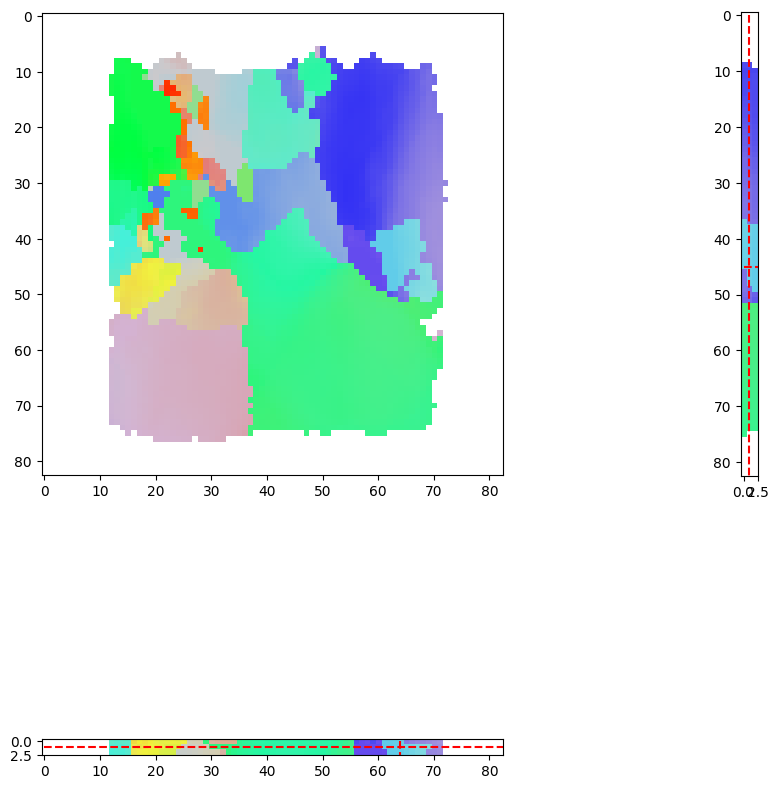

In [8]:
IVP_map_direction_normed = np.array([0, 0, 1])

voxel_of_interest = [45, 64, 1]
volume_shape = coefficients.shape[:3]
pos = (3,2,1)

fig = plt.figure(figsize = (10, 10))
for ii in range(3):

    slc = [slice(None)]*4
    slc[ii] = voxel_of_interest[ii]
    slc = tuple(slc)

    mask_2d = mask[slc[:3]]
    
    
    mean_orientation = np.einsum('xzij,i->xzj', mean_orientation_mat[slc], IVP_map_direction_normed)
    ivp_map_rgb_mean = odftt.plot_tools.IPF_color(mean_orientation, 'cubic')
    ivp_map_rgb_mean[~mask_2d] = 1 # (1 if you want white background, 0 if you want black background )

    plt.subplot(2,2,pos[ii])
    if ii == 0:
        plt.imshow(ivp_map_rgb_mean.transpose((1,0,2)))
        plt.plot([0, volume_shape[1]], [voxel_of_interest[2]]*2, 'r--')
        plt.plot([voxel_of_interest[1]]*2, [0, volume_shape[2]], 'r--')
        plt.xlim([-0.5, volume_shape[1]-0.5]); plt.ylim([volume_shape[2]-0.5, -0.5])
    elif ii == 1:
        plt.imshow(ivp_map_rgb_mean)
        plt.plot([0, volume_shape[2]], [voxel_of_interest[0]]*2, 'r--')
        plt.plot([voxel_of_interest[2]]*2, [0, volume_shape[0]], 'r--')
        plt.xlim([-0.5, volume_shape[2]-0.5]); plt.ylim([volume_shape[0]-0.5, -0.5])
    elif ii == 2:
        plt.imshow(ivp_map_rgb_mean)
        #plt.plot([0, volume_shape[1]], [voxel_of_interest[0]]*2, 'r--')
        #plt.plot([voxel_of_interest[1]]*2, [0, volume_shape[0]], 'r--')
        #plt.xlim([-0.5, volume_shape[1]-0.5]); plt.ylim([volume_shape[0]-0.5, -0.5])
plt.tight_layout()
plt.show()

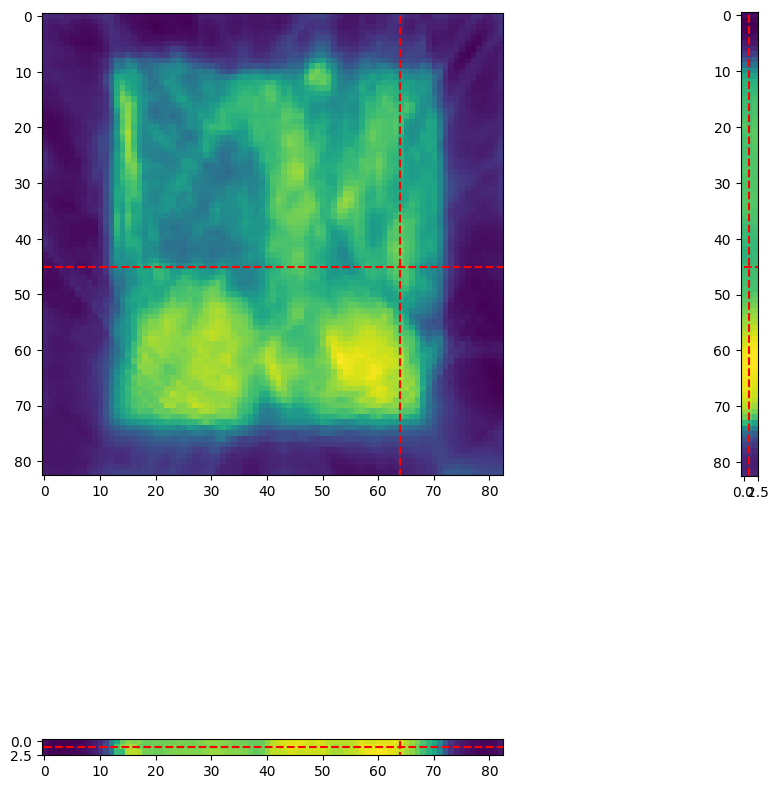

In [9]:

pos = (3,2,1)

fig = plt.figure(figsize = (10, 10))
for ii in range(3):

    plt.subplot(2,2,pos[ii])
    im = np.sum(dens, axis = ii)
    if ii == 0:
        plt.imshow(im.transpose((1,0)))
        plt.plot([0, volume_shape[1]], [voxel_of_interest[2]]*2, 'r--')
        plt.plot([voxel_of_interest[1]]*2, [0, volume_shape[2]], 'r--')
        plt.xlim([-0.5, volume_shape[1]-0.5]); plt.ylim([volume_shape[2]-0.5, -0.5])
    elif ii == 1:
        plt.imshow(im)
        plt.plot([0, volume_shape[2]], [voxel_of_interest[0]]*2, 'r--')
        plt.plot([voxel_of_interest[2]]*2, [0, volume_shape[0]], 'r--')
        plt.xlim([-0.5, volume_shape[2]-0.5]); plt.ylim([volume_shape[0]-0.5, -0.5])
    elif ii == 2:
        plt.imshow(im)
        plt.plot([0, volume_shape[1]], [voxel_of_interest[0]]*2, 'r--')
        plt.plot([voxel_of_interest[1]]*2, [0, volume_shape[0]], 'r--')
        plt.xlim([-0.5, volume_shape[1]-0.5]); plt.ylim([volume_shape[0]-0.5, -0.5])
plt.tight_layout()
plt.show()

In [10]:
# Some options for defining the plot
IVP_map_direction = np.array([0, 0, 1])
pole_figure_hkl = np.array([0, 0, 1])
example_voxel = voxel_of_interest
coeffs_2d = coefficients[:,:,example_voxel[2],:]
stepsize = 0.003
pcolor_opts = {'edgecolors':'face', 'vmin':0, 'rasterized':True}
imshow_opts = {'extent':(0,coeffs_2d.shape[1]*stepsize,coeffs_2d.shape[0]*stepsize,0)}

def tomogram_set_axes(ax):
    ax.set_xlabel('z (mm)')
    ax.set_ylabel('x (mm)')
    # ax.set_xlim(0.9,2.5);
    # ax.set_ylim(2.5, 1.5)
    ax.grid()

# Compute the plotted quantities
mask_2d = np.sum(coeffs_2d, axis = -1) > mask_threshold

# Compute max direction IVP colormap

slc = (slice(None), slice(None), example_voxel[2], slice(None), )
mean_orientation = np.einsum('xzij,i->xzj', mean_orientation_mat[slc], IVP_map_direction_normed)
ivp_map_rgb_mean = odftt.plot_tools.IPF_color(mean_orientation, 'cubic')
ivp_map_rgb_mean[~mask_2d] = 1 # (1 if you want white background, 0 if you want black background )


# Compute approximate texture index
J = np.sqrt(np.var(coeffs_2d, axis = -1)) / np.mean(coeffs_2d, axis = -1)
J[~mask_2d] = np.nan

# Compute a pole-figure of a single voxel
voxel_coeffs = coefficients[example_voxel[0], example_voxel[1], example_voxel[2],:]
polefigure, theta_grid, phi_grid = odf.make_polefigure_map(voxel_coeffs, B @ pole_figure_hkl)


/tmp/ipykernel_3754557/859246560.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_3754557/859246560.py:37: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


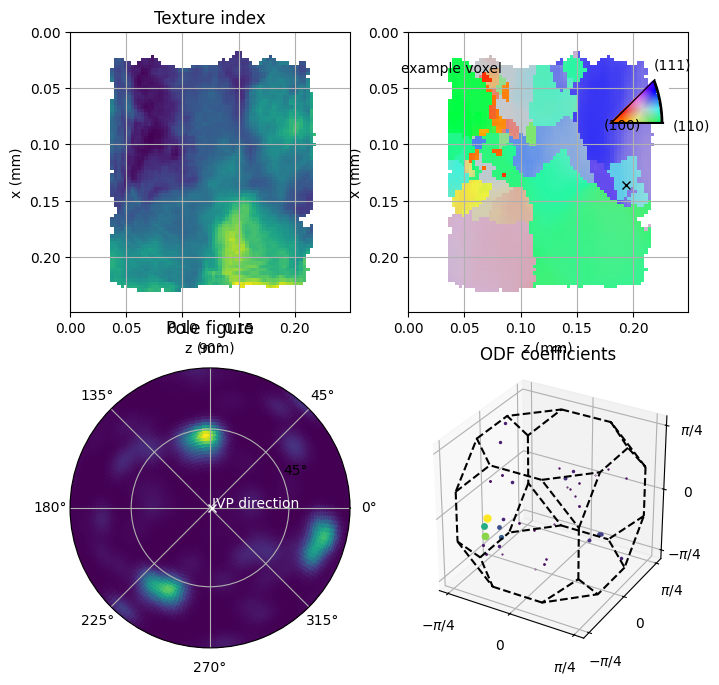

In [11]:
# Build the plot
fig = plt.figure(figsize = (8, 8))

# PLot IVP-map
ax = plt.subplot(2,2,2)
ax.imshow(ivp_map_rgb_mean, **imshow_opts)
ax.plot((example_voxel[1]+0.5)*stepsize, (example_voxel[0]+0.5)*stepsize, 'kx')
ax.text((example_voxel[1]+0.5)*stepsize - 0.2, (example_voxel[0]+0.5)*stepsize - 0.1, 'example voxel', color = 'k')
tomogram_set_axes(ax)
ax = fig.add_subplot([0.8, 0.75, 0.10, 0.10], polar = True)
odftt.plot_tools.make_color_legend(ax, 'cubic')

# Plot texture index
ax = plt.subplot(2,2,1)
img = ax.imshow(J, **imshow_opts)
tomogram_set_axes(ax)
ax.set_title('Texture index')

# PLot pole figure
ax = plt.subplot(2,2,3, polar=True)
img = ax.pcolormesh(phi_grid, np.arctan(theta_grid/2), polefigure, **pcolor_opts)
ax.set_yticks([np.arctan(ii*np.pi/8) for ii in range(1,2)])
ax.set_yticklabels(['45°'])
ax.yaxis.label.set_color('w')
ax.set_title('Pole figure')
if IVP_map_direction_normed[2] < 0.0:
    IVP_map_direction_normed = -IVP_map_direction_normed
IVP_map_theta = np.arccos(IVP_map_direction_normed[2])
IVP_map_phi = np.arctan2(IVP_map_direction_normed[1], IVP_map_direction_normed[0])
ax.plot(IVP_map_phi, np.arctan(IVP_map_theta/2), 'wx')
ax.text(IVP_map_phi+0.3, np.arctan(IVP_map_theta/2), 'IVP direction',color = 'w')

# PLot ODF modes in Rodriguez-vector representation
ax = plt.subplot(2,2,4, projection='3d')
odftt.plot_tools.plot_orientation_coeffs(voxel_coeffs, odf.grid, ax, point_group_string='cubic')
ax.set_title('ODF coefficients')
fig.tight_layout()
fig.show()

/tmp/ipykernel_3754557/859246560.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_3754557/859246560.py:37: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


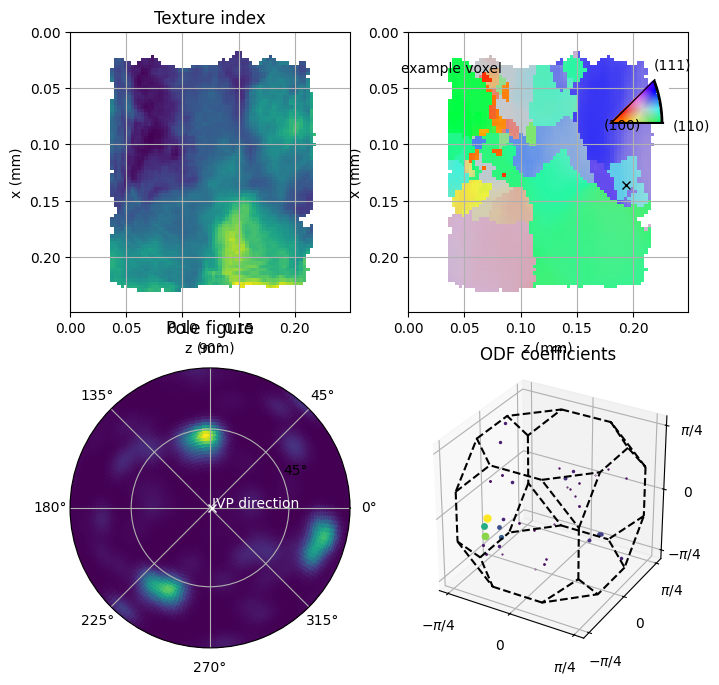

In [12]:
# Build the plot
fig = plt.figure(figsize = (8, 8))

# PLot IVP-map
ax = plt.subplot(2,2,2)
ax.imshow(ivp_map_rgb_mean, **imshow_opts)
ax.plot((example_voxel[1]+0.5)*stepsize, (example_voxel[0]+0.5)*stepsize, 'kx')
ax.text((example_voxel[1]+0.5)*stepsize - 0.2, (example_voxel[0]+0.5)*stepsize - 0.1, 'example voxel', color = 'k')
tomogram_set_axes(ax)
ax = fig.add_subplot([0.8, 0.75, 0.10, 0.10], polar = True)
odftt.plot_tools.make_color_legend(ax, 'cubic')

# Plot texture index
ax = plt.subplot(2,2,1)
img = ax.imshow(J, **imshow_opts)
tomogram_set_axes(ax)
ax.set_title('Texture index')

# PLot pole figure
ax = plt.subplot(2,2,3, polar=True)
img = ax.pcolormesh(phi_grid, np.arctan(theta_grid/2), polefigure, **pcolor_opts)
ax.set_yticks([np.arctan(ii*np.pi/8) for ii in range(1,2)])
ax.set_yticklabels(['45°'])
ax.yaxis.label.set_color('w')
ax.set_title('Pole figure')
if IVP_map_direction_normed[2] < 0.0:
    IVP_map_direction_normed = -IVP_map_direction_normed
IVP_map_theta = np.arccos(IVP_map_direction_normed[2])
IVP_map_phi = np.arctan2(IVP_map_direction_normed[1], IVP_map_direction_normed[0])
ax.plot(IVP_map_phi, np.arctan(IVP_map_theta/2), 'wx')
ax.text(IVP_map_phi+0.3, np.arctan(IVP_map_theta/2), 'IVP direction',color = 'w')

# PLot ODF modes in Rodriguez-vector representation
ax = plt.subplot(2,2,4, projection='3d')
odftt.plot_tools.plot_orientation_coeffs(voxel_coeffs, odf.grid, ax, point_group_string='cubic')
ax.set_title('ODF coefficients')
fig.tight_layout()
fig.show()

## Other analysis you can do 
More inforamations here : https://gitlab.com/liebi-group/software/odf-mumott/-/tree/main/odftt?ref_type=heads